
# Flower Species Classifier Project

Welcome! This project is designed to help you solidify key concepts in deep learning, such as:
- Building and training a Keras model.
- Understanding activation functions (logits, softmax, sigmoid, etc.).
- Using optimizers (especially ADAM) and understanding gradient descent.
- Applying regularization techniques (L1, L2, dropout, and batch normalization).
- Fine-tuning hyperparameters and employing early stopping.
- Evaluating model performance with appropriate metrics.

Let's get started!


In [7]:

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import cifar10

# Set random seed for reproducibility
tf.random.set_seed(42)


# `Sparse representation` versus `One hot encoding`

---

## What do they do
- Represent cateogrical data numerically 
- Where they differ --> How they handle large numbers of categories 

## Sparse  representation 
- More memory efficient 
  - By storing only `non-zero` values 
  - Makes it great for situations where most of the values are 0

## One hot encoding 
- Creates seperate binary column for `each category`
- Doing so can lead to potentially large, sparse matricies when dealing with alot of categories

---

## Reasoning why one hot encoding was picked 
### Simplicity and interpretability
  - One hot encoding super straight forward to implement/interpret 
  - Each class represented by a vector 
    - Elements represented as `1`
    - The rest are represented as `0`
    - Example for 3 classes 
      - Class 0: [1, 0, 0]
      - Class 1: [0, 1, 0]
      - Class 2: [0, 0, 1]

### Compatibility with loss functions
- Most classification loss functions like `cross entropy` 
  - `Expects` target labels to be `one-hot encoded` 
  - This format lets the loss function to compute probabilities for `each class` and `compares them with the actual class label`
- If labels were `NOT` one-hot encoded
  - Model would need extra logic to figure out which class corresponds to the ground truth

## Works well with Softmax
- Softmax function `used in the final layer` in of a multi-class classifier outputs the probabilities for each class 
- One hot encoded labels natrually align with these probabilities making the training process smooth

## Avoids Implicit Ordinal Assumptions 
- Not like integer encoding that would use 0,1,2,3
- One hot encoding ensure the model doesn't interpret the labels as ordinal (having meaningful order)
  - This prevents the model from assuming relationships like "Class 2 > Class 1 > Class 0."


# When is One-Hot Encoding Chosen for Simplicity?
## Small Number of Classes:
- One-hot encoding is especially simple and computationally efficient when the number of classes is small. 
- For example, in the flower classification task, 
  - There might be only 5-10 classes, making one-hot encoding a natural choice.

## Ease of Implementation:
- For beginners, one-hot encoding is easier to understand and implement than alternative methods like label encoding or embeddings.


In [8]:

# # Load the CIFAR-10 dataset (can be replaced with a flower dataset later)
# # What is CIFAR-10 : colection of images used to train ML and CV algorithms
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Normalize images to [0, 1] range
# x_train = x_train.astype("float32") / 255.0
# x_test = x_test.astype("float32") / 255.0

# # One-hot encode labels
# num_classes = 10
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

# # Class names for CIFAR-10 dataset
# CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# #print(len(CLASS_NAMES))

# # Visualize some sample images
# plt.figure(figsize=(10, 5))
# for i in range(len(CLASS_NAMES)):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(x_train[i])
#     plt.title(CLASS_NAMES[np.argmax(y_train[i])])
#     plt.axis("off")
# plt.show()


# Load the dataset (e.g., CIFAR-10 or any flower dataset)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Prepare training and testing datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(buffer_size=1024)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

input_shape = x_train.shape[1:]  # Get the input shape for the model

print("Input shape : ", input_shape)

Input shape :  (32, 32, 3)


# Notes 

## MaxPooling2D(poolSize_)
- Reference link : https://keras.io/api/layers/pooling_layers/max_pooling2d/
- Syntax: keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None, **kwargs)
- Downsamples input along it's spatial dimensions (heigh and width)
- Done by taking `maximum value` over an input window of `size defined by pool_size` for each channel of the input
- The window mentioned is shifted by `strides` along each dimension 
- Resulting output 
  - When using the `valid` padding
    - Has a spatial shape (number of rows x columns) of `output_shape = math.floor((input_shape - pool_size) / strides) + 1 `
    - Only when `input_shape >= pool_size`
  - When using the `same` padding option : `output_shape = math.floor((input_shape - 1) / strides) + 1`

## BatchNormalization()
- `What does it do`
  - Normalizes the inputs to a layer across the mini batch to have :
    - A mean of `0`
    - A standard deviation of `1`
  - `Speeds up training `
    - When nomralizing the inputs, BN `reduces the amount` by which the internal network activations shift during training
      - Aka : `internal covariate shift`
    - Doing so `allows model to converge faster` and `reduce sensitivity to initial weights`
  - `Reduces dependence on initialization `
    - W/o BN
      - Neural networks usually sensitive to the `initialization of weights` 
      - Poor initialization --> Slow training or failture to converge 

## Purpose of flattening a tensor
- `Converts Multi-dimensional Data into a Linear Format`
  - Ensures compatibility between `convolutional layer` to the `fully connected layers`
    - Note 
    -   Convolutional layers : work with 2D/3D tensors 
    -   The fully connected layers expect a 1D input
  -   As mentioned earlier, flattening ensures compatibility between the layers
-   Preserves relevant features 
    -   Keeps spatial information extracted by previous layers such as
        -   Convolutions 
        -   Pooling
    -   Flattening converts it into a single vector 
-   Simplifies matrix operations 
    -   Dense layer work with 1D arrays are both simpler and computationally efficient when it comes to dealing with linear data structures and matrix multplication 
-   Enables integration with dense layers 
    -   Dense layers require the input vector format to compute the `dot product` between weights and inputs 
    -   Flattening provides this format
-   Flattening ensures compatibility with other libraries 
    -   Makes transferring data to libraries/frameworks outside the neural networks alot easier 
    -   For cases like further data analysis or further processing
-   Flattening supports various output shapes
    -   Lets you adapt the output of convolutional layers; depending on kernel size/stride/input shapes, to a fixed-size intput for dense layers 
    -   Makes the model flexible 

In [9]:

# Define a CNN model
def build_model(input_shape, num_classes):
    filters = 32
    kernalSize = (3,3)
    poolSize_ = (2,2) # Tuple --> Immutable collection of elements 

    model = Sequential([
        # Conv2D(Filters,KernelSize,Strides,Padding,ActivationFunction)
        # Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)
        Conv2D(filters,kernalSize, activation='relu', input_shape=input_shape),

        # keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None, **kwargs
        #MaxPooling2D(((2,2))),
        MaxPooling2D(((poolSize_))),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

'''
    input_shape = x_train.shape[1:]
        - Extract shape of the input data, excluding the batch size
        - shape[1:]
            - Python slicing 
            - Extracts subset of a sequence like a tuple/list/array
            - Takes all elements of the shape starting from the SECOND element since this indexes at 0
                - This results in x_train.shape[1:] resulting in (32,32,3)
        - Neural network input shapes 
            - When defining models in Keras the input shape tells the model the dimensions of the data for each sample
        
    Why is this important in NN
        - Generalization across batches 
            - The model works with any batch size during training/inference 
            - By excludingg the batch size the input shape can adapt dynamically
        - Defining layers
            - Layers like Input() or Conv2D() needs the input shape to be known to process the data 
            - Providing the input shape ensure the model is built correctly
                
 
'''

input_shape = x_train.shape[1:]
model = build_model(input_shape, num_classes)
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,106 (1.21 MB)

 Trainable params: 315,914 (1.21 MB)

 Non-trainable params: 192 (768.00 B)

In [10]:
# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to training data
datagen.fit(x_train)


In [ ]:

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10


/home/digital101/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-20 21:33:23.611567: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-20 2

782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.3003 - loss: 2.2945 - val_accuracy: 0.3894 - val_loss: 1.9877
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4696 - loss: 1.4769 - val_accuracy: 0.5440 - val_loss: 1.2864
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5104 - loss: 1.3771 - val_accuracy: 0.5454 - val_loss: 1.3219
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.5395 - loss: 1.2944 - val_accuracy: 0.5960 - val_loss: 1.1524
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.5590 - loss: 1.2433 - val_accuracy: 0.6267 - val_loss: 1.0557
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.5657 - loss: 1.2250 - val_accuracy: 0.5852 - val_loss: 1.1653
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5784 - loss: 1.1953 - val_accuracy: 0.6486 - val_loss: 1.0128
Epoch 8/10
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5879 - loss: 1.1609

KeyError: 'test_accuracy'

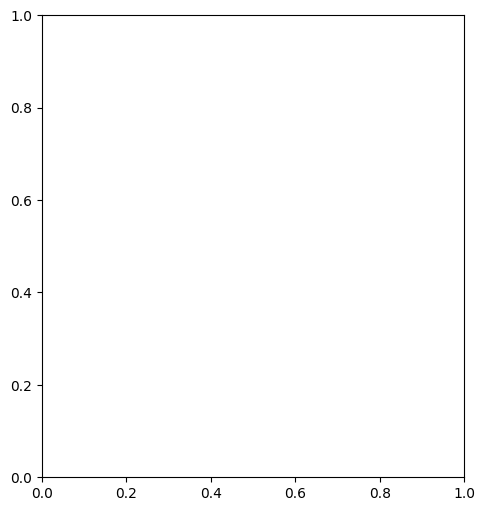

In [33]:

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()
